In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Jun  1 10:04:03 2020

@author: naveen_p

"""

import torch
import torch.nn as nn
import torch.nn.functional as F

class Bottleneck(nn.Module):
    def __init__(self,
                 channels,
                 internal_ratio=4,
                 kernel_size=3,
                 padding =1,
                 dilation=1,
                 asymmetric=False,
                 dropout_prob=0,
                 bias=False,
                 relu=True):
        super().__init__()

        # Check in the internal_scale parameter is within the expected range
        # [1, channels]
        if internal_ratio <= 1 or internal_ratio > channels:
            raise RuntimeError("Value out of range. Expected value in the "
                               "interval [1, {0}], got internal_scale={1}."
                               .format(channels, internal_ratio))

        internal_channels = channels // internal_ratio

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # Main branch - shortcut connection

        # 1x1 projection convolution
        self.ext_conv1 = nn.Sequential(
            nn.Conv2d(
                channels,
                internal_channels,
                kernel_size=1,
                stride=1,
                bias=bias), nn.BatchNorm2d(internal_channels), activation())


        self.ext_conv2 = nn.Sequential(
             nn.Conv2d(
                internal_channels,
                internal_channels,
                kernel_size=kernel_size,
                stride=1,
                padding=padding,
                dilation=dilation,
                bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # 1x1 expansion convolution
        self.ext_conv3 = nn.Sequential(
            nn.Conv2d(
                internal_channels,
                channels,
                kernel_size=1,
                stride=1,
                bias=bias), nn.BatchNorm2d(channels), activation())

        self.ext_regul = nn.Dropout2d(p=dropout_prob)
        # PReLU layer to apply after adding the branches
        self.out_activation = activation()

    def forward(self, x):
        # Main branch shortcut
        main = x
        # Extension branch
        ext = self.ext_conv1(x)
        ext = self.ext_conv2(ext)
        ext = self.ext_conv3(ext)
        ext = self.ext_regul(ext)
        # Add main and extension branches
        out = main + ext
        return self.out_activation(out)

class AnamNet(nn.Module):

    def __init__(self):

        super(AnamNet, self).__init__()

        # Conv block 1 - Down 1
        self.conv1_block = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64,
                      kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            )
        self.max1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # BottleNeck 1
        self.bottleneck1 = Bottleneck(64)


        # Conv block 2 - Down 2
        self.conv2_block = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128,
                      kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
        self.max2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # BottleNeck 2
        self.bottleneck2 = Bottleneck(128)

        # Conv block 3 - Down 3
        self.conv3_block = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256,
                      kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
        self.max3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # BottleNeck 3
        self.bottleneck3 = Bottleneck(256)

        # Conv block 4 - Down 4
        self.conv4_block = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256,
                      kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
        self.max4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Up 1
        self.up_1 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=2, stride=2)

        self.bottleneck4 = Bottleneck(256)
        # Up Conv block 1
        self.conv_up_1 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256,
                      kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )

        # Up 2
        self.up_2 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=2, stride=2)
        
        self.bottleneck5 =Bottleneck(256)  
        # Up Conv block 2
        self.conv_up_2 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256,
                      kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )

        # Up 3
        self.up_3 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2)

        self.bottleneck6 =   Bottleneck(128)
        # Up Conv block 3
        self.conv_up_3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128,
                      kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )

        # Up 4
        self.up_4 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2)

        # Up Conv block 4
        self.conv_up_4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64,
                      kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )

        # Final output
        self.conv_final = nn.Conv2d(in_channels=64, out_channels=3,
                                    kernel_size=1, padding=0, stride=1)

    def forward(self, x):
        
        #print('inputTensor', x.shape)
        #---------------------------------------------------------------------
        # Down 1
        x = self.conv1_block(x)
        #print('after conv1', x.shape)
        conv1_out = x  # Save out1
        conv1_dim = x.shape[2]
        x = self.max1(x)
        #print('after pool1', x.shape)
        #--------------------------------------------------------------------
        x = self.bottleneck1(x)
        #print('after bnck1', x.shape)
        # Down 2
        x = self.conv2_block(x)
        #print('after conv2', x.shape)
        conv2_out = x
        conv2_dim = x.shape[2]
        x = self.max2(x)
        #print('after pool2', x.shape)
        #-------------------------------------------------------------------
        x = self.bottleneck2(x)
        #print('after bnck2', x.shape)
        # Down 3
        x = self.conv3_block(x)
        #print('after conv3', x.shape)
        conv3_out = x
        conv3_dim = x.shape[2]
        x = self.max3(x)
        #print('after pool3', x.shape)
        #------------------------------------------------------------------
        x = self.bottleneck3(x)
        #print('after bnck3', x.shape)
        # Down 4
        x = self.conv4_block(x)
        #print('after conv4', x.shape)
        conv4_out = x
        conv4_dim = x.shape[2]
        x = self.max4(x)
        #print('after pool4', x.shape)
        #----------------------------------------------------------------        
        # Up 1
        x = self.up_1(x)
        #print('after  up_1', x.shape)
        x = self.bottleneck4(x)
        #print('after bnck4', x.shape)
        x = torch.cat([x, conv4_out], dim=1)
        #print('after cat_1',x.shape)        
        x = self.conv_up_1(x)
        #print('after conv1', x.shape)
        #-----------------------------------------------------------------
        # Up 2
        x = self.up_2(x)
        #print('after  up_2', x.shape)
        x = self.bottleneck5(x)
        #print('after bnck5', x.shape)
        x = torch.cat([x, conv3_out], dim=1)
        #print('after cat_2', x.shape)
        x = self.conv_up_2(x)
        #print('after conv2', x.shape)
        #----------------------------------------------------------------
        # Up 3
        x = self.up_3(x)
        #print('after  up_3', x.shape)
        x = self.bottleneck6(x)
        #print('after bnck6', x.shape)
        x = torch.cat([x, conv2_out], dim=1)
        #print('after cat_3', x.shape)
        x = self.conv_up_3(x)
        #print('after conv3', x.shape)
        #----------------------------------------------------------------
        # Up 4
        x = self.up_4(x)
        #print('after  up_3', x.shape)
        x = torch.cat([x, conv1_out], dim=1)
        #print('after cat_4', x.shape)
        x = self.conv_up_4(x)
        #print('after conv4', x.shape)
        # Final output
        x = self.conv_final(x)
        #print('Finaloutshape',x.shape)
        x = F.softmax(x,dim=1)
        x = torch.argmax(x,dim=1).squeeze().float()
        #-----------------------------------------------------------------
        return x

    
    




In [16]:
import scipy.io as io
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import numpy as np
from google.colab import files

import warnings
warnings.warn("deprecated", DeprecationWarning)
warnings.simplefilter("ignore")

net = AnamNet().cuda()
data = io.loadmat('sampledata.mat')
net.load_state_dict(torch.load('model.pth',map_location=torch.device('cpu')))
net.eval()

inp1 = data['im1']
inp1 = np.reshape(inp1,(512,512,1))
inp1 = transforms.ToTensor()(inp1).cuda().unsqueeze(dim=0)
out1 = net(inp1).detach().cpu().numpy()

inp2 = data['im2']
inp2 = np.reshape(inp2,(512,512,1))
inp2 = transforms.ToTensor()(inp2).cuda().unsqueeze(dim=0)
out2 = net(inp2).detach().cpu().numpy()

inp3 = data['im3']
inp3 = np.reshape(inp3,(512,512,1))
inp3 = transforms.ToTensor()(inp3).cuda().unsqueeze(dim=0)
out3 = net(inp3).detach().cpu().numpy()

inp4 = data['im4']
inp4 = np.reshape(inp4,(512,512,1))
inp4 = transforms.ToTensor()(inp4).cuda().unsqueeze(dim=0)
out4 = net(inp4).detach().cpu().numpy()



# Input CT Slices

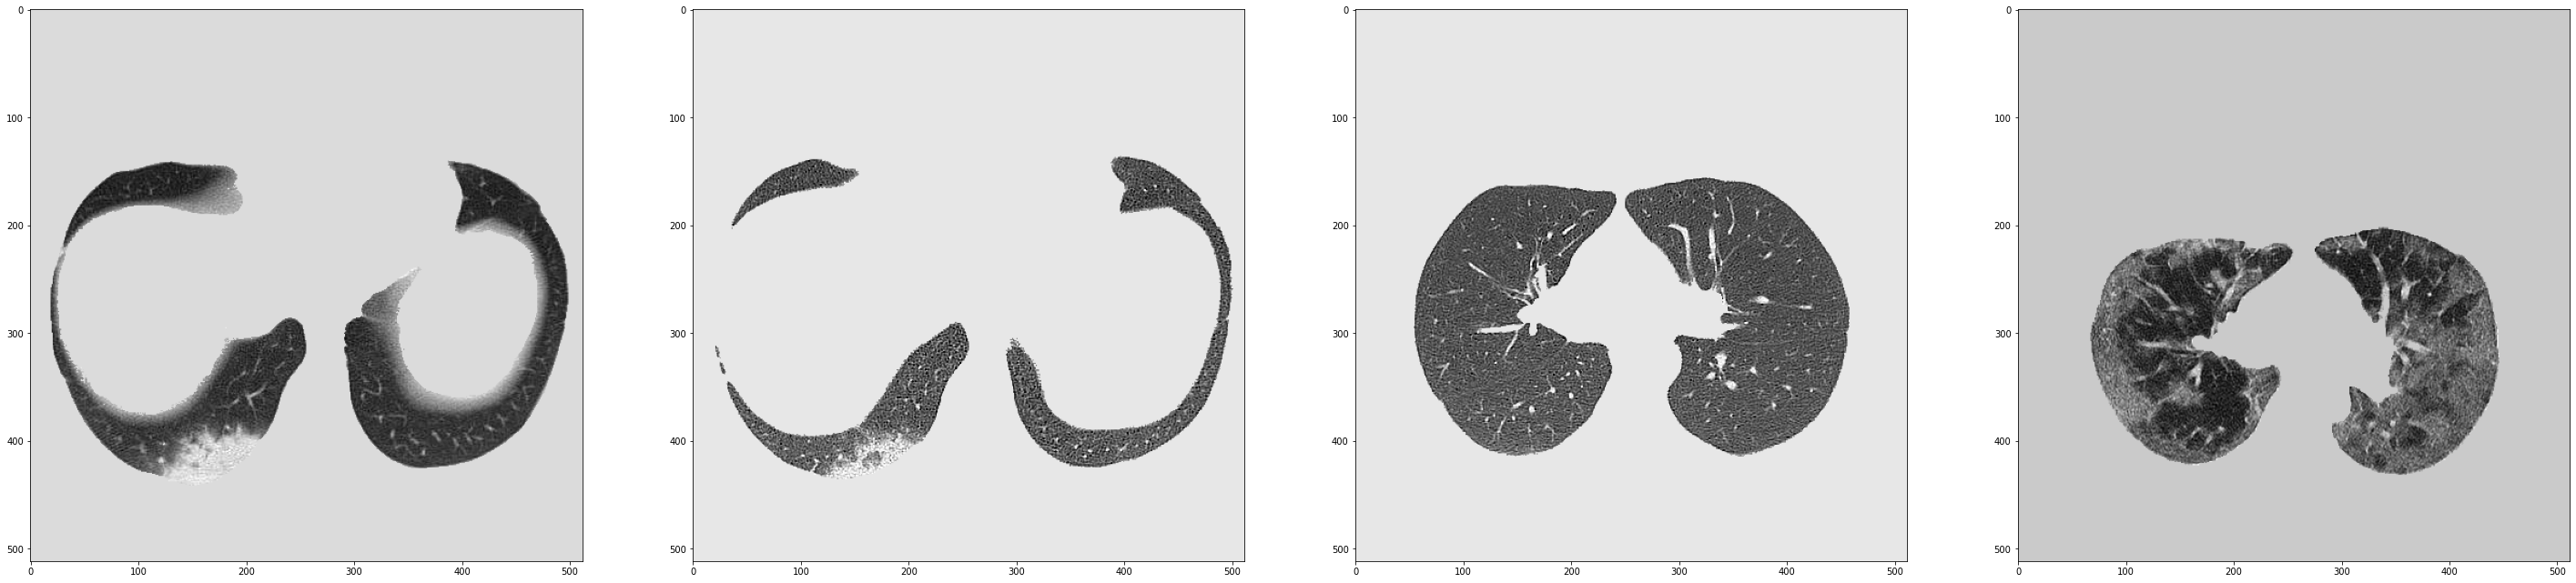

In [17]:
fig, axs = plt.subplots(1, 4, figsize=(50, 50))
axs[0].imshow(data['im1'],cmap='gray')
axs[1].imshow(data['im2'],cmap='gray')
axs[2].imshow(data['im3'],cmap='gray')
axs[3].imshow(data['im4'],cmap='gray')

# Anam-Net Prediction

**Green :**  Infected Tissue    

**Yellow:**  Healthy  Tissue    

**Purple:**Non-Lung Region

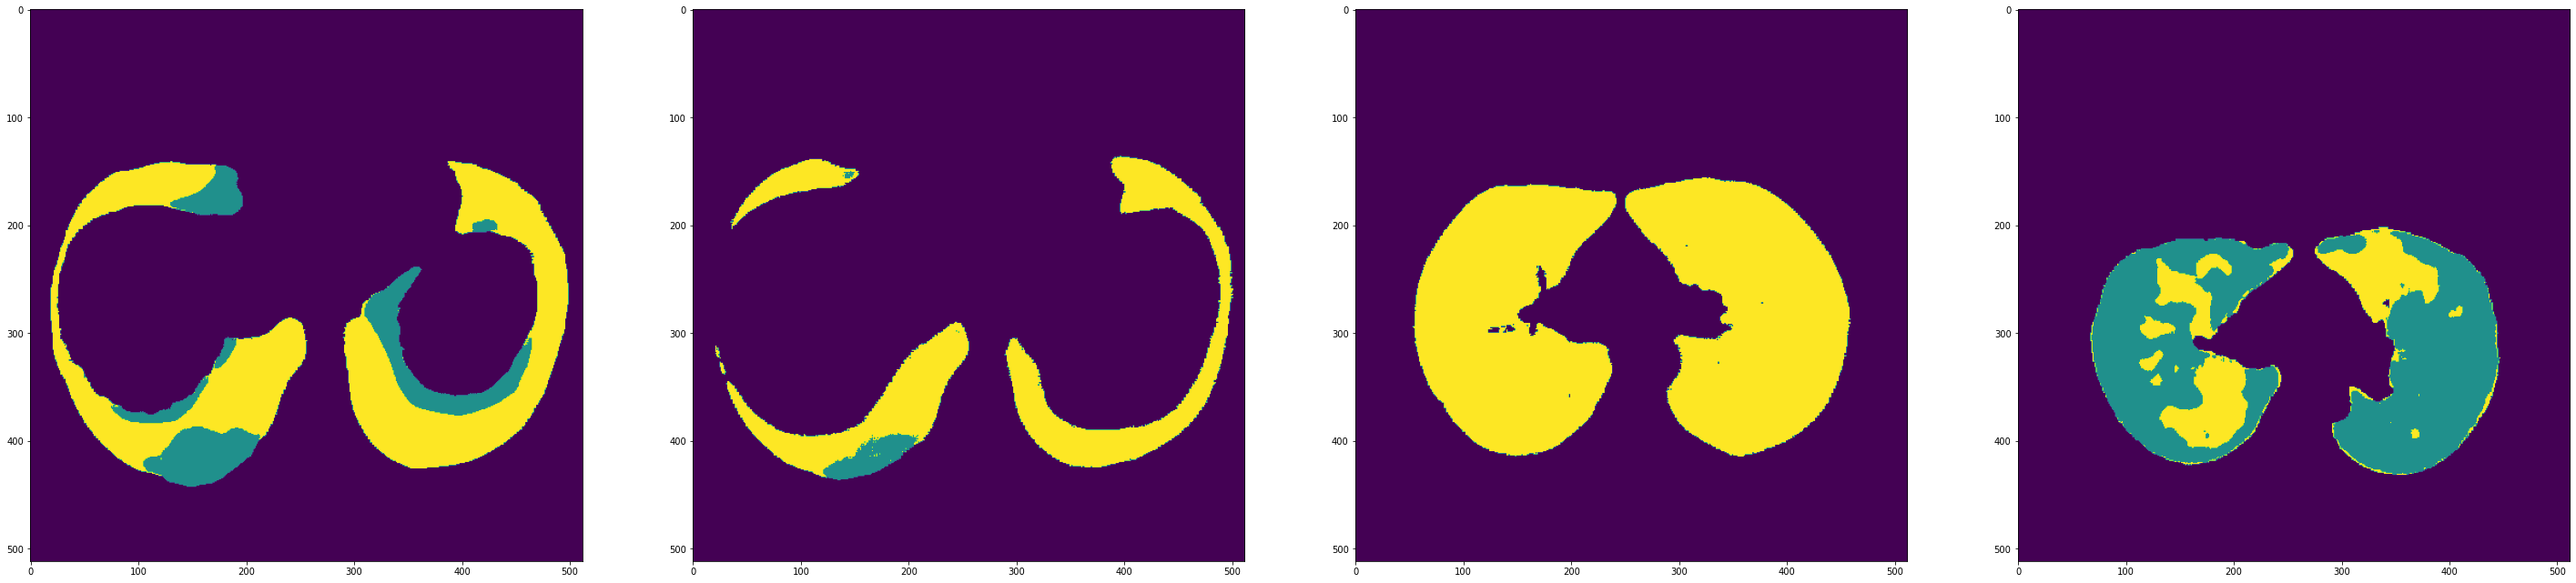

In [21]:
fig, axs = plt.subplots(1, 4, figsize=(50, 50))
axs[0].imshow(out1)
axs[1].imshow(out2)
axs[2].imshow(out3)
axs[3].imshow(out4)